In [ ]:
from google.colab import files
import pandas as pd
uploaded = files.upload()
df = pd.read_csv("Rare_diseases_842_final.xlsx - Hoja1.csv")

df.head()


Saving Rare_diseases_842_final.xlsx - Hoja1.csv to Rare_diseases_842_final.xlsx - Hoja1.csv


,file,subject_id,diagnosis,label,source
0,0,100001,SEPSIS. SEPTICEMIA AGE >17. Sepsis. Infection ...,common,mimic-3-demo
1,1,100002,HEPATITIS B. DISORDERS OF LIVER EXCEPT MALIGNA...,common,mimic-3-demo
2,2,100003,SEPSIS. SEPTICEMIA AGE >17. Unspecified septic...,common,mimic-3-demo
3,3,100004,HUMERAL FRACTURE. Shoulder Upper Arm & Forear...,common,mimic-3-demo
4,4,100005,ALCOHOLIC HEPATITIS. SEPTICEMIA AGE >17. Unspe...,common,mimic-3-demo


In [ ]:
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


# stopwords
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()  # lowercase
        text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
        text = ' '.join([word for word in text.split() if word not in stop_words])  # remove stopwords
        return text
    return ""

df['clean_text'] = df['diagnosis'].apply(preprocess_text)

# TF-IDF vectorization with unigrams and trigrams max_features = 10000 (paper used 5k and 10k) i will try this later
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000, norm='l2')
X_tfidf = vectorizer.fit_transform(df['clean_text'])
print("TF-IDF matrix shape:", X_tfidf.shape)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


TF-IDF matrix shape: (842, 10000)


In [ ]:
df.head()

,file,subject_id,diagnosis,label,source,clean_text
0,0,100001,SEPSIS. SEPTICEMIA AGE >17. Sepsis. Infection ...,common,mimic-3-demo,sepsis septicemia age 17 sepsis infection infl...
1,1,100002,HEPATITIS B. DISORDERS OF LIVER EXCEPT MALIGNA...,common,mimic-3-demo,hepatitis b disorders liver except malignancy ...
2,2,100003,SEPSIS. SEPTICEMIA AGE >17. Unspecified septic...,common,mimic-3-demo,sepsis septicemia age 17 unspecified septicemi...
3,3,100004,HUMERAL FRACTURE. Shoulder Upper Arm & Forear...,common,mimic-3-demo,humeral fracture shoulder upper arm forearm pr...
4,4,100005,ALCOHOLIC HEPATITIS. SEPTICEMIA AGE >17. Unspe...,common,mimic-3-demo,alcoholic hepatitis septicemia age 17 unspecif...


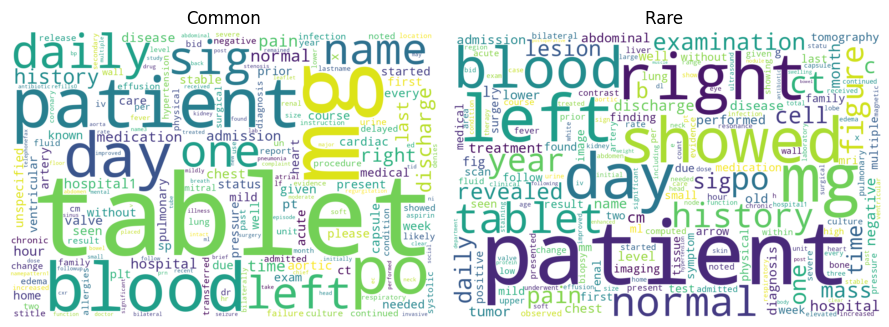

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import os


df['clean_text'] = df['clean_text'].fillna('').astype(str)
df['label'] = df['label'].astype(str).str.strip().str.lower()

common_text = " ".join(df.loc[df['label']=='common', 'clean_text'])
rare_text   = " ".join(df.loc[df['label']=='rare',   'clean_text'])

wc_common = WordCloud(width=1200, height=800, background_color="white",
                      stopwords=STOPWORDS, collocations=False).generate(common_text)
wc_rare   = WordCloud(width=1200, height=800, background_color="white",
                      stopwords=STOPWORDS, collocations=False).generate(rare_text)

plt.figure(figsize=(9,5))
plt.subplot(1,2,1); plt.imshow(wc_common, interpolation="bilinear"); plt.axis("off"); plt.title("Common")
plt.subplot(1,2,2); plt.imshow(wc_rare,   interpolation="bilinear"); plt.axis("off"); plt.title("Rare ")
plt.tight_layout(); plt.show()


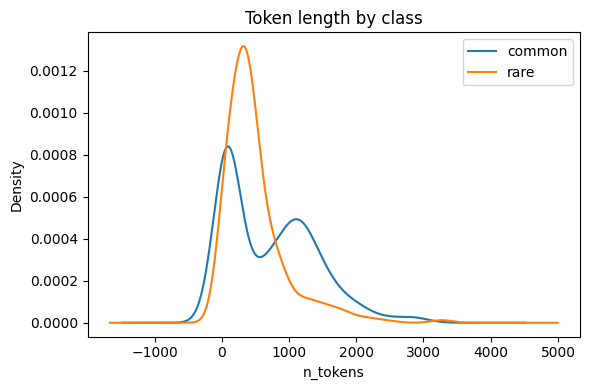

In [ ]:
df['n_tokens'] = df['clean_text'].str.split().apply(len)
df[['n_tokens']].describe()

plt.figure(figsize=(6,4))
for lab in ['common','rare']:
    df.loc[df.label==lab, 'n_tokens'].plot(kind='kde', label=lab)
plt.legend(); plt.title("Token length by class"); plt.xlabel("n_tokens"); plt.tight_layout(); plt.show()



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

# per-model feature
vec_lr_dt = TfidfVectorizer(max_features=10000, ngram_range=(1,3), norm='l2')
vec_svm   = TfidfVectorizer(max_features=10000, ngram_range=(1,3), norm='l1')

X_lr_dt = vec_lr_dt.fit_transform(df['clean_text'])
X_svm   = vec_svm.fit_transform(df['clean_text'])
y = df['label']  # rare or common

def bin_metrics(y_true, y_pred, y_prob_rare):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, pos_label='rare')
    y_true_bin = (y_true == 'rare').astype(int)
    auc = roc_auc_score(y_true_bin, y_prob_rare)
    return acc, f1, auc

sss = StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=42)
res = {'LR': [], 'SVM': [], 'DT': []}

for tr, te in sss.split(X_lr_dt, y):
 #  LR (L2 features)
    lr = LogisticRegression(solver='newton-cg', C=1.0, max_iter=1000)
    lr.fit(X_lr_dt[tr], y.iloc[tr])
    pred = lr.predict(X_lr_dt[te])
    prob_rare = lr.predict_proba(X_lr_dt[te])[:, list(lr.classes_).index('rare')]
    res['LR'].append(bin_metrics(y.iloc[te], pred, prob_rare))

 # SVM (sigmoid, L1 features, C2)
    svm = SVC(kernel='sigmoid', C=2, probability=True)
    svm.fit(X_svm[tr], y.iloc[tr])
    pred = svm.predict(X_svm[te])
    prob_rare = svm.predict_proba(X_svm[te])[:, list(svm.classes_).index('rare')]
    res['SVM'].append(bin_metrics(y.iloc[te], pred, prob_rare))

  #Decision Tree (L2 features, depth=23)
    dt = DecisionTreeClassifier(max_depth=23, random_state=0)
    dt.fit(X_lr_dt[tr], y.iloc[tr])
    pred = dt.predict(X_lr_dt[te])
    prob_rare = dt.predict_proba(X_lr_dt[te])[:, list(dt.classes_).index('rare')]
    res['DT'].append(bin_metrics(y.iloc[te], pred, prob_rare))

# Report mean  (Acc, F1(rare+), AUC)
for m in res:
    arr = np.array(res[m])  # columns:acc, f1, auc
    print(f"{m}: "
          f"Acc {arr[:,0].mean():.3f}±{arr[:,0].std():.3f} | "
          f"F1(rare) {arr[:,1].mean():.3f}±{arr[:,1].std():.3f} | "
          f"AUC {arr[:,2].mean():.3f}±{arr[:,2].std():.3f}")


LR: Acc 0.862±0.016 | F1(rare) 0.852±0.019 | AUC 0.914±0.019
SVM: Acc 0.861±0.017 | F1(rare) 0.847±0.020 | AUC 0.900±0.021
DT: Acc 0.789±0.028 | F1(rare) 0.790±0.027 | AUC 0.788±0.029


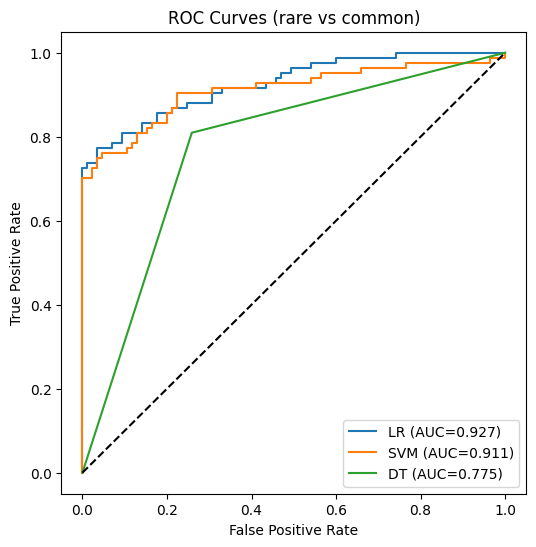

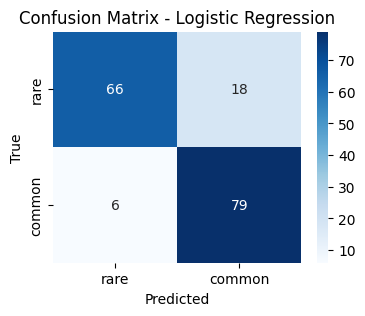

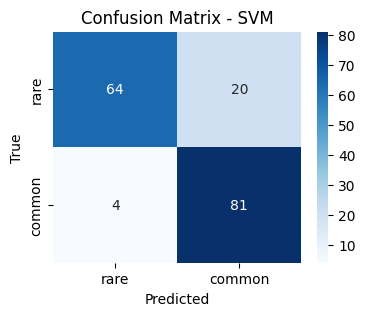

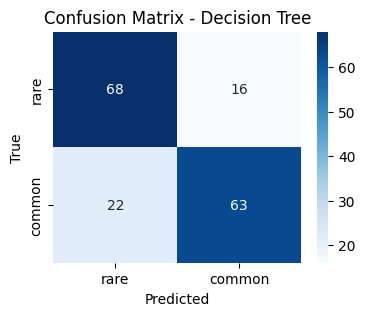

In [ ]:

from sklearn.metrics import confusion_matrix, roc_curve, auc


# one representative split (1)for plots
train_idx, test_idx = next(sss.split(X_lr_dt, y))

#  Logistic Regression
lr = LogisticRegression(solver='newton-cg', C=1.0, max_iter=1000)
lr.fit(X_lr_dt[train_idx], y.iloc[train_idx])
pred_lr = lr.predict(X_lr_dt[test_idx])
prob_lr = lr.predict_proba(X_lr_dt[test_idx])[:, list(lr.classes_).index('rare')]

# SVM
svm = SVC(kernel='sigmoid', C=2, probability=True)
svm.fit(X_svm[train_idx], y.iloc[train_idx])
pred_svm = svm.predict(X_svm[test_idx])
prob_svm = svm.predict_proba(X_svm[test_idx])[:, list(svm.classes_).index('rare')]

#  Decision Tree
dt = DecisionTreeClassifier(max_depth=23, random_state=0)
dt.fit(X_lr_dt[train_idx], y.iloc[train_idx])
pred_dt = dt.predict(X_lr_dt[test_idx])
prob_dt = dt.predict_proba(X_lr_dt[test_idx])[:, list(dt.classes_).index('rare')]

#  to plot ROC curve
def plot_roc(y_true, prob, label):
    y_bin = (y_true == 'rare').astype(int)## rare 1(pos), common 0(neg)
    fpr, tpr, _ = roc_curve(y_bin, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.3f})")

plt.figure(figsize=(6,6))
plot_roc(y.iloc[test_idx], prob_lr, "LR")
plot_roc(y.iloc[test_idx], prob_svm, "SVM")
plot_roc(y.iloc[test_idx], prob_dt, "DT")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (rare vs common)")
plt.legend()
plt.show()



#cm
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['rare','common'])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['rare','common'],
                yticklabels=['rare','common'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_cm(y.iloc[test_idx], pred_lr, "Confusion Matrix - Logistic Regression")
plot_cm(y.iloc[test_idx], pred_svm, "Confusion Matrix - SVM")
plot_cm(y.iloc[test_idx], pred_dt, "Confusion Matrix - Decision Tree")


# **EXPLORING DECISION TREE**

In [ ]:
# === Decision Tree only (30 runs, 80/20, Acc/F1(rare)/AUC) ===
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier


texts = df['clean_text'].astype(str)
y      = df['label']  # 'rare' / 'common'

def bin_metrics(y_true, y_pred, y_prob_rare):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, pos_label='rare')
    y_true_bin = (y_true == 'rare').astype(int)
    auc = roc_auc_score(y_true_bin, y_prob_rare)
    return acc, f1, auc

sss = StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=42)
scores = []

for tr, te in sss.split(texts, y):
 # Fit TF-IDF on TRAIN ONLY (i have to check this later)
    vec = TfidfVectorizer(max_features=10000, ngram_range=(1,3), norm='l2')
    X_tr = vec.fit_transform(texts.iloc[tr])
    X_te = vec.transform(texts.iloc[te])

    # Decision Tree (depth=23)
    dt = DecisionTreeClassifier(max_depth=23, random_state=0)
    dt.fit(X_tr, y.iloc[tr])

    pred = dt.predict(X_te)
    prob_rare = dt.predict_proba(X_te)[:, list(dt.classes_).index('rare')]

    scores.append(bin_metrics(y.iloc[te], pred, prob_rare))

scores = np.array(scores)
print(f"DT: Acc {scores[:,0].mean():.3f}±{scores[:,0].std():.3f} | "
      f"F1(rare) {scores[:,1].mean():.3f}±{scores[:,1].std():.3f} | "
      f"AUC {scores[:,2].mean():.3f}±{scores[:,2].std():.3f}")


print("depth:", dt.get_depth(), "nodes:", dt.tree_.node_count, "leaves:", dt.get_n_leaves())


DT: Acc 0.787±0.034 | F1(rare) 0.790±0.034 | AUC 0.787±0.034
depth: 18 nodes: 83 leaves: 42


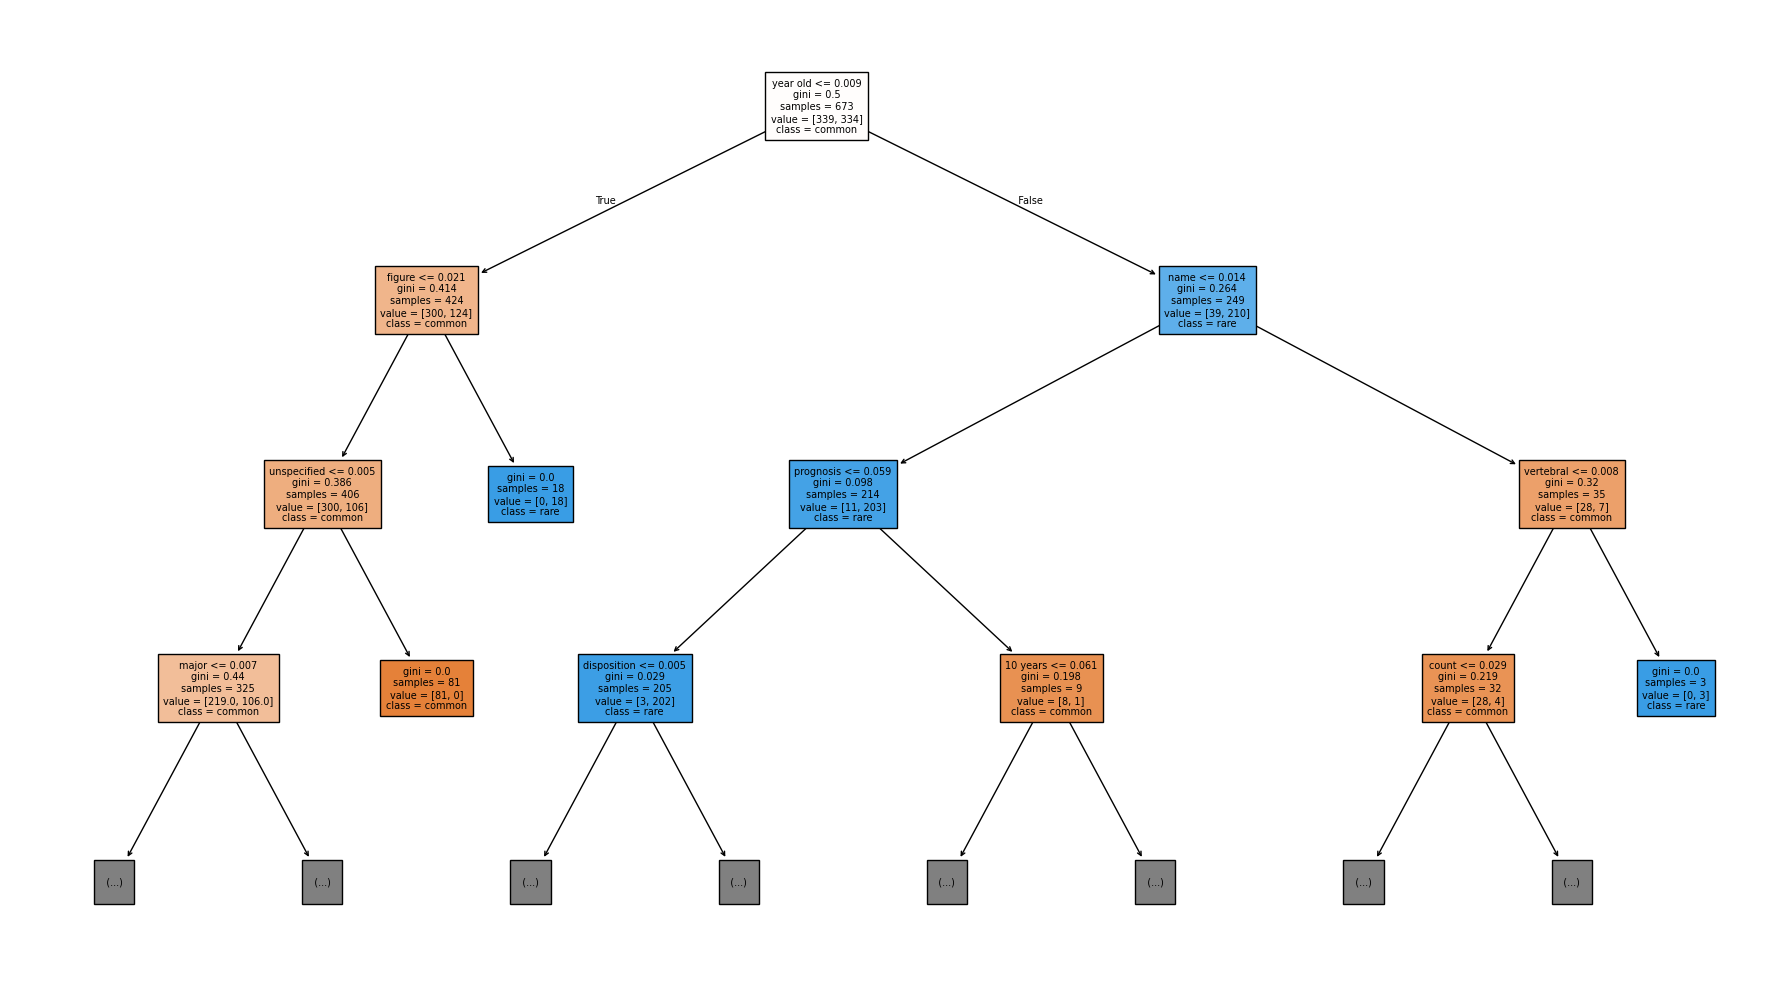

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree

feature_names = vec.get_feature_names_out()
class_names   = ['common', 'rare']


plt.figure(figsize=(18, 10))
tree.plot_tree(
    dt,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    max_depth=3,     # show top levels only to keep it readable-i should expand this to get more
    fontsize=7
)
plt.tight_layout()
plt.show()


# LIME


In [ ]:
!pip install lime
from lime.lime_text import LimeTextExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=adae304dbf3c8cf461361e77f9020368794fae13f4a255fdf3638e4c3639b9dd
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


**RARE**

In [ ]:


from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import display, HTML
from scipy.sparse import csr_matrix


def explain_text(user_text, max_features=15):
    # model wrapper
    def predict_proba_text(raw):
        X = vec.transform(pd.Series(raw).astype(str))
        return dt.predict_proba(X)

    probs = predict_proba_text([user_text])[0]
    print(f"Model probabilities -> common: {probs[0]:.4f}, rare: {probs[1]:.4f}")

    exp_text = None
    try:
        explainer = LimeTextExplainer(
            class_names=['common','rare'],
            random_state=42,
            split_expression=r'\W+'
        )
        exp_text = explainer.explain_instance(
            user_text,
            predict_proba_text,
            labels=[0,1],
            num_features=max_features,
            num_samples=10000,
        )
        # check if weights are all ~0 or prob is extreme?
        w_rare = [abs(w) for _, w in exp_text.as_list(label=1)]
        if probs[1] in (0.0, 1.0) or (len(w_rare) and max(w_rare) < 1e-4):
            exp_text = None  # force fallback
    except Exception:
        exp_text = None

    if exp_text is not None:
        print("\nLIME-Text (class: rare) top features:")
        for f, w in exp_text.as_list(label=1):
            print(f"{f:30s} {w:+.5f}")
        display(HTML(exp_text.as_html()))
        return

    # 2) Fallback: LIME-Tabular on TF-IDF (worksr to DT)
    print("\n[LIME-Text uninformative -> Falling back to LIME-Tabular on TF-IDF]")
    X_all = vec.transform(df['clean_text'].astype(str))
    feature_names = vec.get_feature_names_out()
    # small background for kernel
    rng = np.random.RandomState(42)
    bg = rng.choice(X_all.shape[0], size=min(800, X_all.shape[0]), replace=False)
    X_bg_dense = X_all[bg].toarray()

    expl_tab = LimeTabularExplainer(
        training_data=X_bg_dense,
        feature_names=feature_names,
        class_names=['common','rare'],
        mode='classification',
        discretize_continuous=False,
        random_state=42
    )

    x0_dense = vec.transform([user_text]).toarray().ravel()

    def predict_proba_tab(Xdense):
        return dt.predict_proba(csr_matrix(Xdense))

    exp_tab = expl_tab.explain_instance(
        x0_dense,
        predict_proba_tab,
        num_features=max_features,
        labels=[1]  # rare
    )

    print("LIME-Tabular (TF-IDF) — top n-grams toward 'rare':")
    for feat_idx, w in exp_tab.as_map()[1][:max_features]:
        print(f"{feature_names[feat_idx]:30s} {w:+.5f}")

    fig = exp_tab.as_pyplot_figure(label=1)
    plt.title("LIME-Tabular — DT on TF-IDF (class: rare)")
    plt.tight_layout(); plt.show()


Model probabilities -> common: 0.0000, rare: 1.0000

[LIME-Text uninformative -> Falling back to LIME-Tabular on TF-IDF]
LIME-Tabular (TF-IDF) — top n-grams toward 'rare':
ii unspecified type            +0.03044
stated                         +0.01868
valve disorders                -0.01246
microorganisms                 +0.01179
end stage renal                +0.01097
causing adverse                -0.00986
chronic kidney disease         +0.00983
complication type ii           +0.00905
anemia chronic disease         -0.00797
misadventure                   +0.00719
penicillins                    -0.00399
stage renal                    -0.00392
reaction                       +0.00313
hypertensive chronic kidney    +0.00154
causing adverse effects        +0.00137


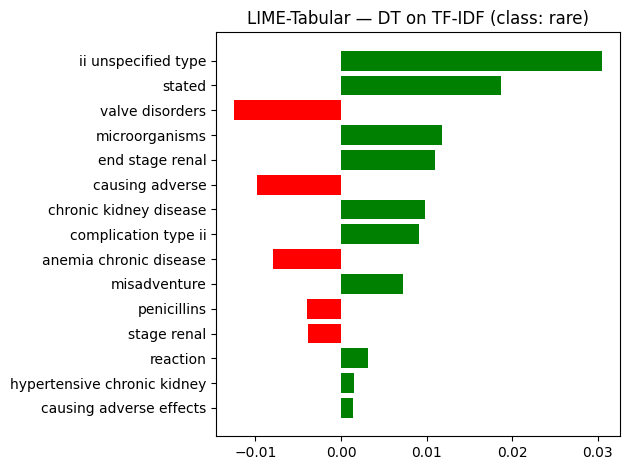

In [ ]:
user_text ="""sepsis septicemia age 17 sepsis infection inflammatory reaction due vascular device implant graft
hypertensive chronic kidney disease unspecified chronic kidney disease stage v end stage renal disease atrial
fibrillation congestive heart failure unspecified aortic valve disorders mitral valve disorders staphylococcal
septicemia tachycardia unspecified kidney dialysis cause abnormal reaction patient later complication without
mention misadventure time procedure infection microorganisms resistant penicillins diverticulitis colon without
mention hemorrhage anemia chronic disease diabetes mellitus without mention complication type ii unspecified type
stated uncontrolled longterm current use insulin anticoagulants causing adverse effects therapeutic use coronary
atherosclerosis native coronary"""
explain_text(user_text, max_features=15)


**COMMON**

In [ ]:
def explain_text(user_text, max_features=15):
    def predict_proba_text(raw):
        X = vec.transform(pd.Series(raw).astype(str))
        return dt.predict_proba(X)

    probs = predict_proba_text([user_text])[0]
    print(f"Model probabilities -> common: {probs[0]:.4f}, rare: {probs[1]:.4f}")

    exp_text = None
    try:
        explainer = LimeTextExplainer(
            class_names=['common','rare'],
            random_state=42,
            split_expression=r'\W+'
        )
        exp_text = explainer.explain_instance(
            user_text,
            predict_proba_text,
            labels=[0,1],
            num_features=max_features,
            num_samples=10000,
        )

        w_common = [abs(w) for _, w in exp_text.as_list(label=0)]
        if probs[0] in (0.0, 1.0) or (len(w_common) and max(w_common) < 1e-4):
            exp_text = None
    except Exception:
        exp_text = None

    if exp_text is not None:
        print("\nLIME-Text (class: common) top features:")
        for f, w in exp_text.as_list(label=0):
            print(f"{f:30s} {w:+.5f}")
        display(HTML(exp_text.as_html(labels=(0,))))  # show common panel
        return

    # Fallback: LIME-Tabular on TF-IDF (class: common)
    print("\n[LIME-Text uninformative -> Falling back to LIME-Tabular on TF-IDF]")
    X_all = vec.transform(df['clean_text'].astype(str))
    feature_names = vec.get_feature_names_out()
    rng = np.random.RandomState(42)
    bg = rng.choice(X_all.shape[0], size=min(800, X_all.shape[0]), replace=False)
    X_bg_dense = X_all[bg].toarray()

    expl_tab = LimeTabularExplainer(
        training_data=X_bg_dense,
        feature_names=feature_names,
        class_names=['common','rare'],
        mode='classification',
        discretize_continuous=False,
        random_state=42
    )

    x0_dense = vec.transform([user_text]).toarray().ravel()
    def predict_proba_tab(Xdense): return dt.predict_proba(csr_matrix(Xdense))

    exp_tab = expl_tab.explain_instance(
        x0_dense,
        predict_proba_tab,
        num_features=max_features,
        labels=[0]    #explain common
    )

    print("LIME-Tabular (TF-IDF) — top n-grams toward 'common':")
    for feat_idx, w in exp_tab.as_map()[0][:max_features]:   # label 0
        print(f"{feature_names[feat_idx]:30s} {w:+.5f}")

    fig = exp_tab.as_pyplot_figure(label=0)
    plt.title("LIME-Tabular — DT on TF-IDF (class: common)")
    plt.tight_layout(); plt.show()


Model probabilities -> common: 1.0000, rare: 0.0000

[LIME-Text uninformative -> Falling back to LIME-Tabular on TF-IDF]
LIME-Tabular (TF-IDF) — top n-grams toward 'common':
history malignant neoplasm     +0.01659
andor hyponatremia             +0.01497
cerebral                       +0.01462
site specified                 -0.01326
specified                      -0.01321
hyposmolality andor hyponatremia -0.01085
intracranial                   -0.01045
history malignant              +0.00913
idiopathic                     +0.00725
anemia unspecified             +0.00520
peripheral neuropathy          +0.00499
neuropathy                     +0.00366
peripheral                     -0.00294
infection site specified       +0.00172
hyposmolality andor            +0.00120


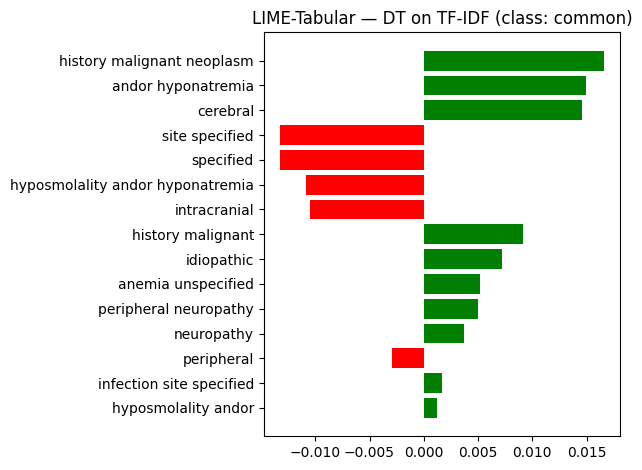

In [ ]:
user_text ="""stroketia intracranial hemorrhage intracranial hemorrhage cerebral infarction intracerebral hemorrhage malignant essential hypertension urinary tract infection site specified hyposmolality andor hyponatremia personal history malignant neoplasm breast unspecified hereditary idiopathic peripheral neuropathy anemia unspecified ...

"""
explain_text(user_text, max_features=15)


In [ ]:


# Encode and predict the whole dataset with the final vec+dt
X_all  = vec.transform(texts)
preds  = dt.predict(X_all)
labels = df['label']
common_idx = np.where(preds == 'common')[0]

print("=== Two texts classified as 'common' by DT ===")
for i in common_idx[:2]:
    print(f"\nIndex {i} | Predicted: {preds[i]} | True: {labels.iloc[i]}")
    print(df['clean_text'].iloc[i][:400], "...")


=== Two texts classified as 'common' by DT ===

Index 5 | Predicted: common | True: common
stroketia intracranial hemorrhage intracranial hemorrhage cerebral infarction intracerebral hemorrhage malignant essential hypertension urinary tract infection site specified hyposmolality andor hyponatremia personal history malignant neoplasm breast unspecified hereditary idiopathic peripheral neuropathy anemia unspecified ...

Index 11 | Predicted: common | True: common
sepsis septicemia age 17 unspecified septicemia septic shock pneumonitis due inhalation food vomitus acute kidney failure unspecified acidosis hyperosmolality andor hypernatremia severe sepsis esophageal reflux alzheimers disease dementia conditions classified elsewhere without behavioral disturbance polymyalgia rheumatica unspecified acquired hypothyroidism ...


# SHAP


In [ ]:
!pip install shap

In [ ]:
import shap
from IPython.display import display

In [ ]:
#trying shap-need to check which version-might change it
def explain_shap_text(user_text: str, topk: int = 15, class_view: str = "pred", bg_size: int = 600):

    X_all_sparse = vec.transform(df['clean_text'].astype(str))
    rng = np.random.RandomState(42)
    bg_idx = rng.choice(X_all_sparse.shape[0], size=min(bg_size, X_all_sparse.shape[0]), replace=False)
    X_bg_dense = X_all_sparse[bg_idx].toarray()

    x = vec.transform([user_text]).toarray()
    feature_names = vec.get_feature_names_out()
    n_features = x.shape[1]

    # Get model prediction for the input
    probs    = dt.predict_proba(x)[0]# probability per class
    classes  = list(dt.classes_)
    n_classes = len(classes)
    pred_idx = int(np.argmax(probs))
    cls_idx  = pred_idx if class_view == "pred" else classes.index(class_view)
    print(f"Model probs -> {classes[0]}: {probs[0]:.4f} | {classes[1]}: {probs[1]:.4f}")
    print("Explaining class:", classes[cls_idx])

    #shap TreeExplainer for Decision Tree
    explainer = shap.TreeExplainer(
        dt, data=X_bg_dense,
        model_output="probability",
        feature_perturbation="interventional"
    )
    shap_values = explainer.shap_values(x)
    base_values = explainer.expected_value

   -
    def extract_sv(sv_obj, cls_idx, n_features, n_classes):
        arr = np.asarray(sv_obj)
        # common: list-of-arrays (n_classes) -> pick class array
        if isinstance(sv_obj, list):
            arr = sv_obj[cls_idx]
        # Cases:
        # (n_samples, n_features)            - pick first sample
        if arr.ndim == 2 and arr.shape == (1, n_features):
            return arr[0]
        # (n_features,)                      - direct vector
        if arr.ndim == 1 and arr.size == n_features:
            return arr
        # (n_classes, n_samples, n_features) - pick class, sample 0
        if arr.ndim == 3 and arr.shape == (n_classes, 1, n_features):
            return arr[cls_idx, 0, :]
        # (n_samples, n_features, n_classes) - pick class on last axis
        if arr.ndim == 3 and arr.shape == (1, n_features, n_classes):
            return arr[0, :, cls_idx]
        # fallback: try to find a length-n_features vector
        for ax in range(arr.ndim):
            if n_features in arr.shape:
                # move that axis to the end and take the first along otherstf
                axes = list(range(arr.ndim))
                axes.remove(arr.shape.index(n_features))
        raise RuntimeError(f"Unexpected SHAP shape: {arr.shape} (n_features={n_features})")

    sv = extract_sv(shap_values, cls_idx, n_features, n_classes)
    base = base_values[cls_idx] if np.ndim(base_values) else float(base_values)
    print(f"Base={base:.4f}, pred={probs[cls_idx]:.4f}, base+sum(SHAP)={base + sv.sum():.4f}")

    # non-zero TF-IDF features only- readable
    nz = np.where(x[0] > 0)[0]
    if nz.size == 0:
        print("\nNo non-zero TF-IDF features for this text with current vectorizer.")
        return

    sv_nz   = sv[nz]
    feats_nz = feature_names[nz]
    vals_nz  = x[0, nz]

    k = min(topk, nz.size)
    order = np.argsort(np.abs(sv_nz))[::-1][:k]

    print("\nTop non-zero features (by |SHAP|):") # Print top contributing words
    for i in order:
        print(f"{feats_nz[i]:35s} {sv_nz[i]:+.5f}")

    exp = shap.Explanation(values=sv_nz[order], base_values=base,
                           data=vals_nz[order], feature_names=feats_nz[order])
    shap.plots.waterfall(exp, max_display=7)  # show top 5 only
    shap.plots.bar(exp, max_display=15)
    plt.title(f"SHAP Waterfall — class: {classes[cls_idx]}")
    plt.tight_layout(); plt.show()


Model probs -> common: 0.0000 | rare: 1.0000
Explaining class: rare
Base=0.4800, pred=1.0000, base+sum(SHAP)=1.0000

Top non-zero features (by |SHAP|):
velocity                            +0.00000
study                               +0.00000
similar                             +0.00000
normal                              +0.00000
mother                              +0.00000
mm                                  +0.00000
intellectual disability             +0.00000
intellectual                        +0.00000
half                                +0.00000
epilepsy                            +0.00000
electrical                          +0.00000
disability                          +0.00000
conduction                          +0.00000


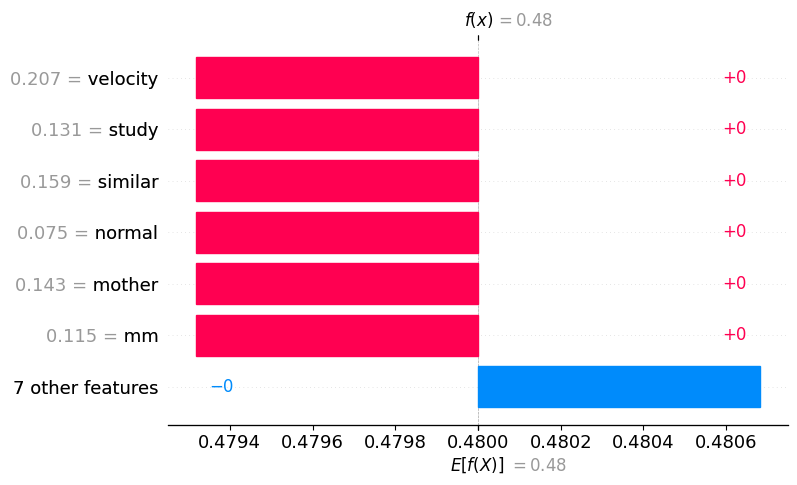

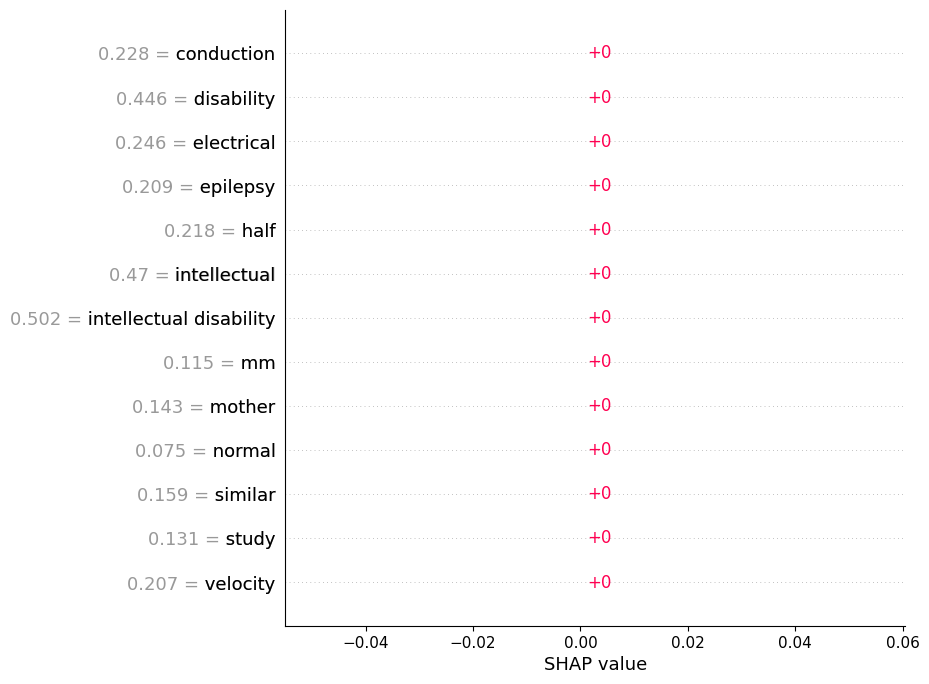

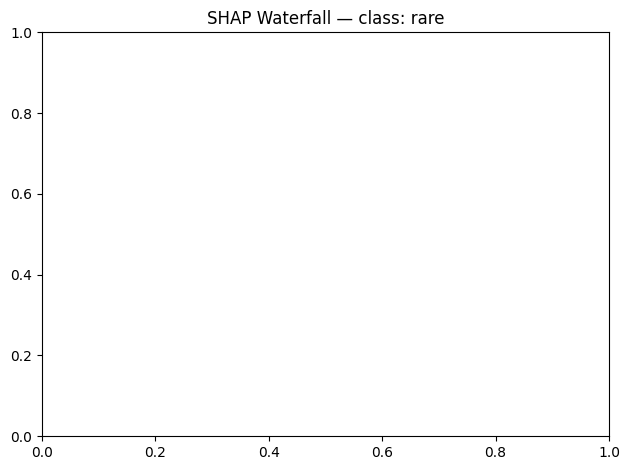

In [ ]:

user_text = """Myopathy (electrical study)  normal conduction velocity in all 4 MM  no myotonic discharges  intellectual disability  dysmorphias. half-sisters and mother  similar phenotype  some epilepsy  intellectual disability
"""
explain_shap_text(user_text, topk=15, class_view="pred")


In [ ]:
# predictions on full dataset
X_all = vec.transform(df['clean_text'].astype(str))
preds = dt.predict(X_all)

i = 117
if preds[i] == 'rare':
    print(f"Index {i} | Predicted: {preds[i]} | True: {df['label'].iloc[i]}")
    print("\nFull text:\n")
    print(df['clean_text'].iloc[i])
else:
    print(f"Index {i} is predicted as '{preds[i]}', not 'rare'.")


Index 117 | Predicted: rare | True: rare

Full text:

deceased child xlinked infantile spinal atrophy severe hypotonia areflexia predominantly distal normal ocular motility distal arthrogryposis camptodactyly cryptorchidism sma studied dna bank genetic counseling preimplantation diagnosis cranial mri nonspecific right perventricular perventricular hyperintensities rest normal


**LSTM**

In [ ]:
# LSTM baseline no external embeddings

import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#configs
NUM_RUNS    = 30
VOCAB_SIZE  = 20000
MAX_LEN     = 300
EMBED_DIM   = 400   # paper's total (they used 200+200)
LSTM_UNITS  = 64
DENSE_UNITS = 64
BATCH_SIZE  = 32
EPOCHS      = 20
LR          = 1e-3
PATIENCE    = 3 # early stopping on validation accuracy


texts  = df['clean_text'].astype(str).values
labels = df['label'].astype(str).values
y_all  = (labels == 'rare').astype(int)

# Model embedding  LSTM(64) - Dense(64) - Softmax 2)
def make_lstm_model(vocab_size, embed_dim):
    inp = layers.Input(shape=(MAX_LEN,), dtype='int32')
    emb = layers.Embedding(vocab_size, embed_dim)(inp)
    x   = layers.LSTM(LSTM_UNITS)(emb)
    x   = layers.Dense(DENSE_UNITS, activation='relu')(x)
    out = layers.Dense(2, activation='softmax')(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# tokenizer fit on train only; 80/20 split; early stopping; eval
def run_once(random_state=None):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    tr_idx, te_idx = next(sss.split(texts, y_all))
    X_tr_text, X_te_text = texts[tr_idx], texts[te_idx]
    y_tr, y_te           = y_all[tr_idx], y_all[te_idx]

    tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
    tok.fit_on_texts(X_tr_text)  # fit on train only

    X_tr = pad_sequences(tok.texts_to_sequences(X_tr_text), maxlen=MAX_LEN)
    X_te = pad_sequences(tok.texts_to_sequences(X_te_text), maxlen=MAX_LEN)
    vocab_size_eff = min(VOCAB_SIZE, len(tok.word_index) + 1)

    # take 10% of train as validation
    val_sz = max(1, int(0.1 * len(X_tr)))
    X_tr_fit, y_tr_fit = X_tr[:-val_sz], y_tr[:-val_sz]
    X_val,    y_val    = X_tr[-val_sz:], y_tr[-val_sz:]

    model = make_lstm_model(vocab_size=vocab_size_eff, embed_dim=EMBED_DIM)
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=PATIENCE,
                                       restore_best_weights=True,
                                       verbose=0)

    model.fit(X_tr_fit, y_tr_fit,
              validation_data=(X_val, y_val),
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              verbose=0,
              callbacks=[es])

    prob = model.predict(X_te, batch_size=256, verbose=0)[:, 1]
    pred = (prob >= 0.5).astype(int)

    acc = accuracy_score(y_te, pred)
    f1  = f1_score(y_te, pred)
    auc = roc_auc_score(y_te, prob)

    keras.backend.clear_session()
    gc.collect()
    return acc, f1, auc

#30 run with mean
scores = np.array([run_once(random_state=None) for _ in range(NUM_RUNS)])
print(f"LSTM (no ext. embeddings): "
      f"Acc {scores[:,0].mean():.3f}±{scores[:,0].std():.3f} | "
      f"F1(rare) {scores[:,1].mean():.3f}±{scores[:,1].std():.3f} | "
      f"AUC {scores[:,2].mean():.3f}±{scores[:,2].std():.3f}")


LSTM (no ext. embeddings): Acc 0.841±0.027 | F1(rare) 0.831±0.028 | AUC 0.905±0.024


Confusion matrix (rows=true [rare, common], cols=pred [rare, common]):
 [[65 19]
 [ 4 81]]


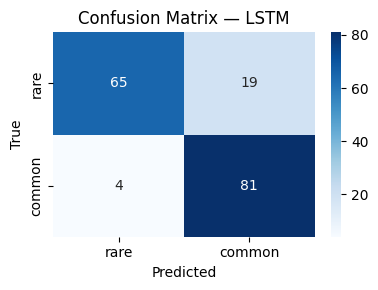

In [ ]:
def lstm_confusion_matrix(random_state=None, threshold=0.5):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    tr_idx, te_idx = next(sss.split(texts, y_all))
    X_tr_text, X_te_text = texts[tr_idx], texts[te_idx]
    y_tr, y_te = y_all[tr_idx], y_all[te_idx]

    # 2) Tokenizer on TRAIN only
    tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
    tok.fit_on_texts(X_tr_text)
    X_tr = pad_sequences(tok.texts_to_sequences(X_tr_text), maxlen=MAX_LEN)
    X_te = pad_sequences(tok.texts_to_sequences(X_te_text), maxlen=MAX_LEN)
    vocab_size_eff = min(VOCAB_SIZE, len(tok.word_index) + 1)

    #10% train as validation
    val_sz = max(1, int(0.1 * len(X_tr)))
    X_tr_fit, y_tr_fit = X_tr[:-val_sz], y_tr[:-val_sz]
    X_val,    y_val    = X_tr[-val_sz:], y_tr[-val_sz:]

    # training model
    model = make_lstm_model(vocab_size=vocab_size_eff, embed_dim=EMBED_DIM)
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE,
                                       restore_best_weights=True, verbose=0)
    model.fit(X_tr_fit, y_tr_fit,
              validation_data=(X_val, y_val),
              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])

   #cm plotting
    prob = model.predict(X_te, batch_size=256, verbose=0)[:, 1]
    y_pred = (prob >= threshold).astype(int)

    cm = confusion_matrix(y_te, y_pred, labels=[1, 0])
    print("Confusion matrix (rows=true [rare, common], cols=pred [rare, common]):\n", cm)


    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['rare','common'], yticklabels=['rare','common'])
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — LSTM")
    plt.tight_layout(); plt.show()
    keras.backend.clear_session(); gc.collect()

    return cm, te_idx, y_pred


cm_lstm, test_idx, y_pred = lstm_confusion_matrix(random_state=None)


# **CNN**

CNN (no ext. embeddings): Acc 0.854±0.024 | F1(rare) 0.845±0.025 | AUC 0.911±0.019
Confusion matrix (rows=true [rare, common], cols=pred [rare, common]):
 [[62 22]
 [ 6 79]]


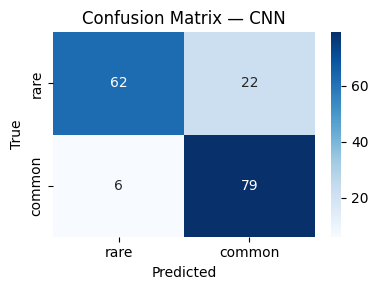

In [ ]:


#Model hyperparameters
FILTERS     = 70
KERNELS     = [1, 2, 3, 4]
DENSE_UNITS = 64
DROP        = 0.2# dropout rate to reduce overfitting

#data
texts  = df['clean_text'].astype(str).values
labels = df['label'].astype(str).values
y_all  = (labels == 'rare').astype(int)


#  CNN model (Embedding 400- Conv branches - GlobalMaxPool - Concat - Dense64 - Dropout0.2 - Softmax2)
def make_cnn_model(vocab_size, embed_dim=EMBED_DIM):
    inp = layers.Input(shape=(MAX_LEN,), dtype='int32')
    emb = layers.Embedding(vocab_size, embed_dim)(inp)

    branches = []
    for k in KERNELS: # Build 4 parallel conv branches with different kernel sizes
        b = layers.Conv1D(FILTERS, k, padding='same', activation='relu')(emb)
        b = layers.GlobalMaxPooling1D()(b)
        branches.append(b)

    x = layers.Concatenate()(branches)# Concatenate pooled features from all branches into one vector
    x = layers.Dense(DENSE_UNITS, activation='relu')(x)
    x = layers.Dropout(DROP)(x)
    out = layers.Dense(2, activation='softmax')(x)

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#  80/20 run for metrics
def run_once_cnn(random_state=None):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    tr_idx, te_idx = next(sss.split(texts, y_all))
    X_tr_text, X_te_text = texts[tr_idx], texts[te_idx]
    y_tr, y_te           = y_all[tr_idx], y_all[te_idx]

    # ttokenizer on train only
    tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
    tok.fit_on_texts(X_tr_text)
    X_tr = pad_sequences(tok.texts_to_sequences(X_tr_text), maxlen=MAX_LEN)
    X_te = pad_sequences(tok.texts_to_sequences(X_te_text), maxlen=MAX_LEN)
    vocab_size_eff = min(VOCAB_SIZE, len(tok.word_index) + 1)

    # 10% train as validation
    val_sz = max(1, int(0.1 * len(X_tr)))
    X_tr_fit, y_tr_fit = X_tr[:-val_sz], y_tr[:-val_sz]
    X_val,    y_val    = X_tr[-val_sz:], y_tr[-val_sz:]

#  Buildtrain the CNN
    model = make_cnn_model(vocab_size=vocab_size_eff, embed_dim=EMBED_DIM)
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE,
                                       restore_best_weights=True, verbose=0)
    model.fit(X_tr_fit, y_tr_fit,
              validation_data=(X_val, y_val),
              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])
#  Predict on test set
    prob = model.predict(X_te, batch_size=256, verbose=0)[:, 1]
    pred = (prob >= 0.5).astype(int)

    acc = accuracy_score(y_te, pred)
    f1  = f1_score(y_te, pred)
    auc = roc_auc_score(y_te, prob)

    keras.backend.clear_session(); gc.collect()
    return acc, f1, auc

#repeat the whole procedure NUM_RUNS times with new splits then report mean
cnn_scores = np.array([run_once_cnn(random_state=None) for _ in range(NUM_RUNS)])
print(f"CNN (no ext. embeddings): "
      f"Acc {cnn_scores[:,0].mean():.3f}±{cnn_scores[:,0].std():.3f} | "
      f"F1(rare) {cnn_scores[:,1].mean():.3f}±{cnn_scores[:,1].std():.3f} | "
      f"AUC {cnn_scores[:,2].mean():.3f}±{cnn_scores[:,2].std():.3f}")

# train1- cm plot
def cnn_confusion_matrix(random_state=None, threshold=0.5):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    tr_idx, te_idx = next(sss.split(texts, y_all))
    X_tr_text, X_te_text = texts[tr_idx], texts[te_idx]
    y_tr, y_te           = y_all[tr_idx], y_all[te_idx]

    tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
    tok.fit_on_texts(X_tr_text)
    X_tr = pad_sequences(tok.texts_to_sequences(X_tr_text), maxlen=MAX_LEN)
    X_te = pad_sequences(tok.texts_to_sequences(X_te_text), maxlen=MAX_LEN)
    vocab_size_eff = min(VOCAB_SIZE, len(tok.word_index) + 1)

## Validation slice from train for early stopping
    val_sz = max(1, int(0.1 * len(X_tr)))
    X_tr_fit, y_tr_fit = X_tr[:-val_sz], y_tr[:-val_sz]
    X_val,    y_val    = X_tr[-val_sz:], y_tr[-val_sz:]

    model = make_cnn_model(vocab_size=vocab_size_eff, embed_dim=EMBED_DIM)
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE,
                                       restore_best_weights=True, verbose=0)
    model.fit(X_tr_fit, y_tr_fit,
              validation_data=(X_val, y_val),
              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])

    prob = model.predict(X_te, batch_size=256, verbose=0)[:, 1]
    y_pred = (prob >= threshold).astype(int)
#CM and plot
    cm = confusion_matrix(y_te, y_pred, labels=[1, 0])
    print("Confusion matrix (rows=true [rare, common], cols=pred [rare, common]):\n", cm)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['rare','common'], yticklabels=['rare','common'])
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — CNN")
    plt.tight_layout(); plt.show()

    keras.backend.clear_session(); gc.collect()
    return cm, te_idx, y_pred

#testing it
cm_cnn, test_idx_cnn, y_pred_cnn = cnn_confusion_matrix(random_state=None)


# **HYBRID**

CNN→LSTM (no ext. embeddings): Acc 0.829±0.029 | F1(rare) 0.824±0.029 | AUC 0.904±0.021
Confusion matrix (rows=true [rare, common], cols=pred [rare, common]):
 [[68 16]
 [13 72]]


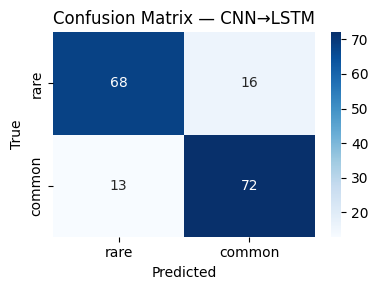

In [ ]:

# CNN- LSTM hybrid
#Reused global configs (from LSTM)NUM_RUNS, VOCAB_SIZE, MAX_LEN, EMBED_DIM, BATCH_SIZE, EPOCHS, LR, PATIENCE i already definedd

# CNN-LSTM
CONV_FILTERS = 50
KERNELS      = [1, 2, 3, 4]#size
LSTM_UNITS_H = 50
DENSE_UNITS  = 50
DROPOUT      = 0.2

texts  = df['clean_text'].astype(str).values
labels = df['label'].astype(str).values
y_all  = (labels == 'rare').astype(int)

# --- Model: Emb(400) - [Conv1D(k=1..4, f=50)] -Concat (sequence kept) -LSTM(50) - Dense(50) - Dropout(0.2) - Softmax(2)
def make_cnn_lstm_model(vocab_size, embed_dim=EMBED_DIM):
    inp = layers.Input(shape=(MAX_LEN,), dtype='int32')
    emb = layers.Embedding(vocab_size, embed_dim)(inp)
 # Parallel conv branches; didnt  pool yet bc LSTM
    branches = []
    for k in KERNELS:
        b = layers.Conv1D(CONV_FILTERS, k, padding='same', activation='relu')(emb)
        #  no pooling here; keep sequence for LSTM
        branches.append(b)

    # Concatfrom all branches
    x = layers.Concatenate(axis=-1)(branches)  # shape: (batch, MAX_LEN, CONV_FILTERS*len(KERNELS))

    x = layers.LSTM(LSTM_UNITS_H)(x)# LSTM reads the sequence of conv features and produces a single vector
    x = layers.Dense(DENSE_UNITS, activation='relu')(x)
    x = layers.Dropout(DROPOUT)(x)
    out = layers.Dense(2, activation='softmax')(x)

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#One 80/20
def run_once_cnn_lstm(random_state=None):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    tr_idx, te_idx = next(sss.split(texts, y_all))
    X_tr_text, X_te_text = texts[tr_idx], texts[te_idx]
    y_tr, y_te           = y_all[tr_idx], y_all[te_idx]

    # Tokenizer on train only
    tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
    tok.fit_on_texts(X_tr_text)
    X_tr = pad_sequences(tok.texts_to_sequences(X_tr_text), maxlen=MAX_LEN)
    X_te = pad_sequences(tok.texts_to_sequences(X_te_text), maxlen=MAX_LEN)
    vocab_size_eff = min(VOCAB_SIZE, len(tok.word_index) + 1)

    # 10% train as validation
    val_sz = max(1, int(0.1 * len(X_tr)))
    X_tr_fit, y_tr_fit = X_tr[:-val_sz], y_tr[:-val_sz]
    X_val,    y_val    = X_tr[-val_sz:], y_tr[-val_sz:]
    # Build/train the CNN-LSTM model
    model = make_cnn_lstm_model(vocab_size=vocab_size_eff, embed_dim=EMBED_DIM)
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE,
                                       restore_best_weights=True, verbose=0)
    model.fit(X_tr_fit, y_tr_fit,
              validation_data=(X_val, y_val),
              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])

    prob = model.predict(X_te, batch_size=256, verbose=0)[:, 1]
    pred = (prob >= 0.5).astype(int)

    acc = accuracy_score(y_te, pred)
    f1  = f1_score(y_te, pred)
    auc = roc_auc_score(y_te, prob)

    keras.backend.clear_session(); gc.collect()
    return acc, f1, auc

#30 runs (mean-std)
cnn_lstm_scores = np.array([run_once_cnn_lstm(random_state=None) for _ in range(NUM_RUNS)])
print(f"CNN→LSTM (no ext. embeddings): "
      f"Acc {cnn_lstm_scores[:,0].mean():.3f}±{cnn_lstm_scores[:,0].std():.3f} | "
      f"F1(rare) {cnn_lstm_scores[:,1].mean():.3f}±{cnn_lstm_scores[:,1].std():.3f} | "
      f"AUC {cnn_lstm_scores[:,2].mean():.3f}±{cnn_lstm_scores[:,2].std():.3f}")

#train1 -cm plot CNN-LSTM
def cnn_lstm_confusion_matrix(random_state=None, threshold=0.5):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    tr_idx, te_idx = next(sss.split(texts, y_all))
    X_tr_text, X_te_text = texts[tr_idx], texts[te_idx]
    y_tr, y_te           = y_all[tr_idx], y_all[te_idx]

    tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
    tok.fit_on_texts(X_tr_text)
    X_tr = pad_sequences(tok.texts_to_sequences(X_tr_text), maxlen=MAX_LEN)
    X_te = pad_sequences(tok.texts_to_sequences(X_te_text), maxlen=MAX_LEN)
    vocab_size_eff = min(VOCAB_SIZE, len(tok.word_index) + 1)

    val_sz = max(1, int(0.1 * len(X_tr)))
    X_tr_fit, y_tr_fit = X_tr[:-val_sz], y_tr[:-val_sz]
    X_val,    y_val    = X_tr[-val_sz:], y_tr[-val_sz:]

    model = make_cnn_lstm_model(vocab_size=vocab_size_eff, embed_dim=EMBED_DIM)
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE,
                                       restore_best_weights=True, verbose=0)
    model.fit(X_tr_fit, y_tr_fit,
              validation_data=(X_val, y_val),
              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])

    prob = model.predict(X_te, batch_size=256, verbose=0)[:, 1]
    y_pred = (prob >= threshold).astype(int)

    cm = confusion_matrix(y_te, y_pred, labels=[1, 0])
    print("Confusion matrix (rows=true [rare, common], cols=pred [rare, common]):\n", cm)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['rare','common'], yticklabels=['rare','common'])
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — CNN→LSTM")
    plt.tight_layout(); plt.show()

    keras.backend.clear_session(); gc.collect()
    return cm, te_idx, y_pred


cm_cnn_lstm, test_idx_cnn_lstm, y_pred_cnn_lstm = cnn_lstm_confusion_matrix(random_state=None)


LSTM→CNN (no ext. embeddings): Acc 0.832±0.032 | F1(rare) 0.826±0.032 | AUC 0.902±0.023
Confusion matrix (rows=true [rare, common], cols=pred [rare, common]):
 [[66 18]
 [10 75]]


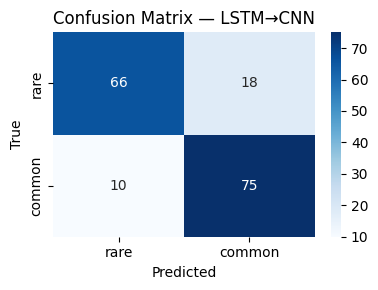

In [ ]:

# LSTM - CNN hybrid
# Reuse existing globals: NUM_RUNS, VOCAB_SIZE, MAX_LEN, EMBED_DIM, BATCH_SIZE, EPOCHS, LR, PATIENCE

texts  = df['clean_text'].astype(str).values
labels = df['label'].astype(str).values
y_all  = (labels == 'rare').astype(int)

#LSTM-CNN small sizes (paper)
LSTM_UNITS_SMALL = 16
CONV_FILTERS     = 10
KERNELS          = [1, 2, 3, 4]

def make_lstm_cnn_model(vocab_size, embed_dim=EMBED_DIM):
    inp = layers.Input(shape=(MAX_LEN,), dtype='int32')
    emb = layers.Embedding(vocab_size, embed_dim)(inp)

    # LSTM first-keep the sequence CNN
    x = layers.LSTM(LSTM_UNITS_SMALL, return_sequences=True)(emb)

    # Small CNN branches (no Dense-64, no Dropout in this variant)
    branches = []
    for k in KERNELS:
        b = layers.Conv1D(CONV_FILTERS, k, padding='same', activation='relu')(x)
        b = layers.GlobalMaxPooling1D()(b)
        branches.append(b)

    x = layers.Concatenate()(branches)
    out = layers.Dense(2, activation='softmax')(x)

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 80/20
def run_once_lstm_cnn(random_state=None):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    tr_idx, te_idx = next(sss.split(texts, y_all))
    X_tr_text, X_te_text = texts[tr_idx], texts[te_idx]
    y_tr, y_te           = y_all[tr_idx], y_all[te_idx]

    tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
    tok.fit_on_texts(X_tr_text)
    X_tr = pad_sequences(tok.texts_to_sequences(X_tr_text), maxlen=MAX_LEN)
    X_te = pad_sequences(tok.texts_to_sequences(X_te_text), maxlen=MAX_LEN)
    vocab_size_eff = min(VOCAB_SIZE, len(tok.word_index) + 1)

    # 10% of train as validation
    val_sz = max(1, int(0.1 * len(X_tr)))
    X_tr_fit, y_tr_fit = X_tr[:-val_sz], y_tr[:-val_sz]
    X_val,    y_val    = X_tr[-val_sz:], y_tr[-val_sz:]

    model = make_lstm_cnn_model(vocab_size=vocab_size_eff, embed_dim=EMBED_DIM)
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE,
                                       restore_best_weights=True, verbose=0)
    model.fit(X_tr_fit, y_tr_fit,
              validation_data=(X_val, y_val),
              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])

    prob = model.predict(X_te, batch_size=256, verbose=0)[:, 1]
    pred = (prob >= 0.5).astype(int)

    acc = accuracy_score(y_te, pred)
    f1  = f1_score(y_te, pred)
    auc = roc_auc_score(y_te, prob)

    keras.backend.clear_session(); gc.collect()
    return acc, f1, auc

# 30 runs (mean-std)
lstm_cnn_scores = np.array([run_once_lstm_cnn(random_state=None) for _ in range(NUM_RUNS)])
print(f"LSTM→CNN (no ext. embeddings): "
      f"Acc {lstm_cnn_scores[:,0].mean():.3f}±{lstm_cnn_scores[:,0].std():.3f} | "
      f"F1(rare) {lstm_cnn_scores[:,1].mean():.3f}±{lstm_cnn_scores[:,1].std():.3f} | "
      f"AUC {lstm_cnn_scores[:,2].mean():.3f}±{lstm_cnn_scores[:,2].std():.3f}")

# lstm cnn cm plot-train1
def lstm_cnn_confusion_matrix(random_state=None, threshold=0.5):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    tr_idx, te_idx = next(sss.split(texts, y_all))
    X_tr_text, X_te_text = texts[tr_idx], texts[te_idx]
    y_tr, y_te           = y_all[tr_idx], y_all[te_idx]

    tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
    tok.fit_on_texts(X_tr_text)
    X_tr = pad_sequences(tok.texts_to_sequences(X_tr_text), maxlen=MAX_LEN)
    X_te = pad_sequences(tok.texts_to_sequences(X_te_text), maxlen=MAX_LEN)
    vocab_size_eff = min(VOCAB_SIZE, len(tok.word_index) + 1)

    val_sz = max(1, int(0.1 * len(X_tr)))
    X_tr_fit, y_tr_fit = X_tr[:-val_sz], y_tr[:-val_sz]
    X_val,    y_val    = X_tr[-val_sz:], y_tr[-val_sz:]

    model = make_lstm_cnn_model(vocab_size=vocab_size_eff, embed_dim=EMBED_DIM)
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE,
                                       restore_best_weights=True, verbose=0)
    model.fit(X_tr_fit, y_tr_fit,
              validation_data=(X_val, y_val),
              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])

    prob = model.predict(X_te, batch_size=256, verbose=0)[:, 1]
    y_pred = (prob >= threshold).astype(int)

    cm = confusion_matrix(y_te, y_pred, labels=[1, 0])
    print("Confusion matrix (rows=true [rare, common], cols=pred [rare, common]):\n", cm)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['rare','common'], yticklabels=['rare','common'])
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — LSTM→CNN")
    plt.tight_layout(); plt.show()

    keras.backend.clear_session(); gc.collect()
    return cm, te_idx, y_pred


cm_lstm_cnn, test_idx_lstm_cnn, y_pred_lstm_cnn = lstm_cnn_confusion_matrix(random_state=None)


# **BERT-base**

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 69.62, 'train_samples_per_second': 9.667, 'train_steps_per_second': 0.618, 'train_loss': 0.5809618927711664, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 60.2186, 'train_samples_per_second': 11.176, 'train_steps_per_second': 0.714, 'train_loss': 0.5873072424600291, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 79.725, 'train_samples_per_second': 8.442, 'train_steps_per_second': 0.539, 'train_loss': 0.5184491179710211, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 83.6074, 'train_samples_per_second': 8.05, 'train_steps_per_second': 0.514, 'train_loss': 0.5061318153558776, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 85.0109, 'train_samples_per_second': 7.917, 'train_steps_per_second': 0.506, 'train_loss': 0.5560457983682322, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 66.3068, 'train_samples_per_second': 10.15, 'train_steps_per_second': 0.649, 'train_loss': 0.5396485439566678, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 54.6436, 'train_samples_per_second': 12.316, 'train_steps_per_second': 0.787, 'train_loss': 0.5986384901889535, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 54.3322, 'train_samples_per_second': 12.387, 'train_steps_per_second': 0.791, 'train_loss': 0.6050810703011447, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 108.1748, 'train_samples_per_second': 6.221, 'train_steps_per_second': 0.398, 'train_loss': 0.6043738431708757, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 40.7925, 'train_samples_per_second': 16.498, 'train_steps_per_second': 1.054, 'train_loss': 0.5649018398551053, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 61.9149, 'train_samples_per_second': 10.87, 'train_steps_per_second': 0.695, 'train_loss': 0.5402782351471657, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 58.8955, 'train_samples_per_second': 11.427, 'train_steps_per_second': 0.73, 'train_loss': 0.5622344793275346, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 58.5738, 'train_samples_per_second': 11.49, 'train_steps_per_second': 0.734, 'train_loss': 0.5050857898800872, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 70.2328, 'train_samples_per_second': 9.582, 'train_steps_per_second': 0.612, 'train_loss': 0.571269013160883, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 56.101, 'train_samples_per_second': 11.996, 'train_steps_per_second': 0.766, 'train_loss': 0.5417702253474745, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 60.452, 'train_samples_per_second': 11.133, 'train_steps_per_second': 0.711, 'train_loss': 0.5456755882085755, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 57.2255, 'train_samples_per_second': 11.76, 'train_steps_per_second': 0.751, 'train_loss': 0.5323711661405341, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 59.5169, 'train_samples_per_second': 11.308, 'train_steps_per_second': 0.722, 'train_loss': 0.5781606629837391, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 59.4165, 'train_samples_per_second': 11.327, 'train_steps_per_second': 0.724, 'train_loss': 0.5608366145644077, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 60.9652, 'train_samples_per_second': 11.039, 'train_steps_per_second': 0.705, 'train_loss': 0.6188221421352652, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 75.8521, 'train_samples_per_second': 8.873, 'train_steps_per_second': 0.567, 'train_loss': 0.5391389713730923, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 51.1719, 'train_samples_per_second': 13.152, 'train_steps_per_second': 0.84, 'train_loss': 0.65093994140625, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 75.5295, 'train_samples_per_second': 8.91, 'train_steps_per_second': 0.569, 'train_loss': 0.5801343696061955, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 55.193, 'train_samples_per_second': 12.194, 'train_steps_per_second': 0.779, 'train_loss': 0.5583076477050781, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 60.3148, 'train_samples_per_second': 11.158, 'train_steps_per_second': 0.713, 'train_loss': 0.5734125181686046, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 58.3462, 'train_samples_per_second': 11.535, 'train_steps_per_second': 0.737, 'train_loss': 0.5529868547306505, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 74.9099, 'train_samples_per_second': 8.984, 'train_steps_per_second': 0.574, 'train_loss': 0.6275265715843024, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 57.7241, 'train_samples_per_second': 11.659, 'train_steps_per_second': 0.745, 'train_loss': 0.5927303225495094, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 81.9301, 'train_samples_per_second': 8.214, 'train_steps_per_second': 0.525, 'train_loss': 0.5604246272597202, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 ...
Epoch 1/1 done.
{'train_runtime': 53.6638, 'train_samples_per_second': 12.541, 'train_steps_per_second': 0.801, 'train_loss': 0.6208558193472928, 'epoch': 1.0}
BERT (base) — over 30 runs, 1 epochs each
Accuracy:    0.804 ± 0.034
F1 (rare=1): 0.794 ± 0.037
AUC:         0.891 ± 0.025
Confusion matrix (rows=true [rare, common], cols=pred [rare, common]):
 [[69 15]
 [ 9 76]]


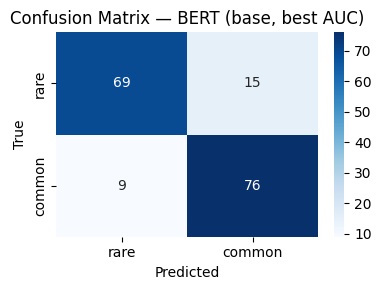

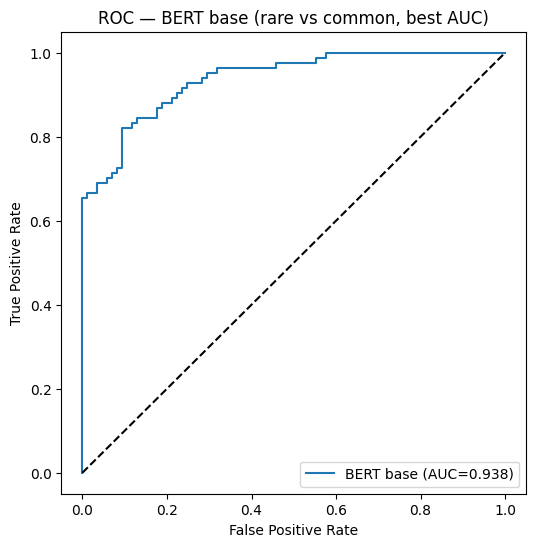

In [ ]:
# Base BERT (bert-base-uncased) — 30 runs, 3 epochs, Acc/F1/AUC + CM
# - qquiet training: prints only epoch lines
# - Computes mean std over 30 runs and plots CM/ROC for the best-AUC split
#testing one epoch

import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments, set_seed, TrainerCallback
)
import inspect
import warnings

MODEL_NAME   = "bert-base-uncased"
MAX_LEN      = 256
LR           = 2e-5
BATCH_TRAIN  = 16
BATCH_EVAL   = 32
EPOCHS       = 1
NUM_RUNS     = 30
SEED         = 42

label2id = {"common": 0, "rare": 1}
id2label = {v: k for k, v in label2id.items()}

# future warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")
assert 'df' in globals(), "Put your data in a DataFrame named `df`."
texts  = df["clean_text"].astype(str).values
labels = df["label"].str.lower().map(label2id).values
assert set(np.unique(labels)) <= {0,1}, "Labels must be 'rare'/'common'."


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
collator  = DataCollatorWithPadding(tokenizer=tokenizer)

class TxtDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tok = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], truncation=True, max_length=self.max_len)
        enc["labels"] = self.labels[i]
        return {k: torch.tensor(v) for k, v in enc.items()}

def _softmax_np(logits):
    z = logits - logits.max(axis=1, keepdims=True)
    p = np.exp(z); p /= p.sum(axis=1, keepdims=True)
    return p


class EpochPrinter(TrainerCallback):# print only epoch numbers
    def __init__(self, total_epochs:int):
        self.total_epochs = total_epochs
        self._e = 0
    def on_epoch_begin(self, args, state, control, **kwargs):
        self._e += 1
        print(f"Epoch {self._e}/{self.total_epochs} ...", flush=True)
    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"Epoch {self._e}/{self.total_epochs} done.", flush=True)


def build_trainer(model, args, train_dataset):
    kw = dict(model=model, args=args, train_dataset=train_dataset, data_collator=collator)
    sig = inspect.signature(Trainer.__init__)
    if "processing_class" in sig.parameters:
        kw["processing_class"] = tokenizer
    else:
        kw["tokenizer"] = tokenizer            # fallback for older versions/other one was better
    tr = Trainer(**kw)
    tr.add_callback(EpochPrinter(total_epochs=EPOCHS))
    return tr

# 30 runs (80/20 split each)-using 1 for testing firs
set_seed(SEED)
sss = StratifiedShuffleSplit(n_splits=NUM_RUNS, test_size=0.2, random_state=SEED)

accs, f1s, aucs = [], [], []
best_auc = -np.inf
best_artifacts = None

for run_id, (tr_idx, te_idx) in enumerate(sss.split(texts, labels), start=1):
    set_seed(SEED + run_id)

    train_ds = TxtDS(texts[tr_idx], labels[tr_idx], tokenizer, MAX_LEN)
    test_ds  = TxtDS(texts[te_idx], labels[te_idx], tokenizer, MAX_LEN)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=2, id2label=id2label, label2id=label2id
    )


    args = TrainingArguments(
        output_dir=f"bert_out/run_{run_id}",
        learning_rate=LR,
        per_device_train_batch_size=BATCH_TRAIN,
        per_device_eval_batch_size=BATCH_EVAL,
        num_train_epochs=EPOCHS,
        report_to="none",                  # no W&B
        disable_tqdm=True,                 # hide progress bar
        logging_steps=10**9,
        fp16=torch.cuda.is_available()
    )

    trainer = build_trainer(model, args, train_ds)
    trainer.train()

    # Predict on test
    preds  = trainer.predict(test_ds)
    logits = preds.predictions if not isinstance(preds.predictions, tuple) else preds.predictions[0]
    probs  = _softmax_np(logits)[:, 1]
    y_true = preds.label_ids
    y_pred = (probs >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, pos_label=1)
    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = np.nan

    accs.append(acc); f1s.append(f1); aucs.append(auc)

    if not np.isnan(auc) and auc > best_auc:
        best_auc = auc
        cm = confusion_matrix(y_true, y_pred, labels=[1,0])
        best_artifacts = (y_true.copy(), probs.copy(), y_pred.copy(), cm.copy())


accs = np.array(accs, dtype=float)
f1s  = np.array(f1s,  dtype=float)
aucs = np.array(aucs, dtype=float)

print(f"BERT (base) — over {NUM_RUNS} runs, {EPOCHS} epochs each")
print(f"Accuracy:    {np.nanmean(accs):.3f} ± {np.nanstd(accs):.3f}")
print(f"F1 (rare=1): {np.nanmean(f1s):.3f} ± {np.nanstd(f1s):.3f}")
print(f"AUC:         {np.nanmean(aucs):.3f} ± {np.nanstd(aucs):.3f}")

# confusion matrix + ROC for best run
if best_artifacts is not None:
    y_true, probs, y_pred, cm = best_artifacts

    print("Confusion matrix (rows=true [rare, common], cols=pred [rare, common]):\n", cm)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['rare','common'], yticklabels=['rare','common'])
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — BERT (base, best AUC)")
    plt.tight_layout(); plt.show()

    fpr, tpr, _ = roc_curve(y_true, probs)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"BERT base (AUC={roc_auc_score(y_true, probs):.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC — BERT base (rare vs common, best AUC)")
    plt.legend(); plt.show()



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]


Run 1/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 2/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 3/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 4/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 5/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 6/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 7/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 8/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 9/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 10/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 11/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 12/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 13/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 14/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 15/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 16/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 17/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 18/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 19/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 20/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 21/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 22/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 23/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 24/30
Epoch 1/1 ...
Epoch 1/1 done.

Run 25/30
Epoch 1/1 ...


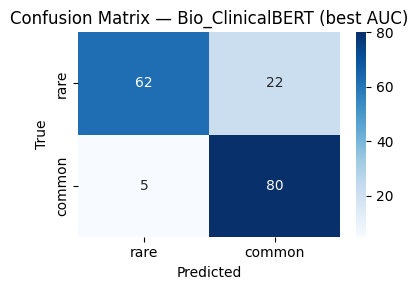

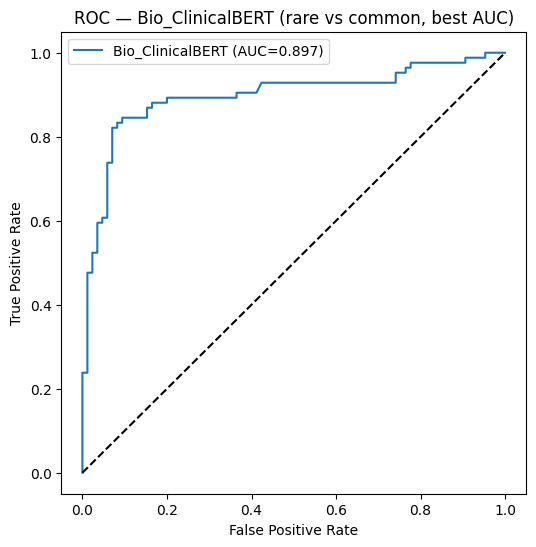

In [ ]:
#  Bio_ClinicalBERT — 30 runs, 3 epochs, Acc/F1/AUC + CM (quiet, epoch-only)
#testing 1 epoch
import inspect, warnings, logging
from transformers.utils import logging as hf_logging

hf_logging.set_verbosity_error()
logging.getLogger("transformers").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")


MODEL_NAME   = "emilyalsentzer/Bio_ClinicalBERT"  # BioBERT (clinical)
MAX_LEN      = 128                                 # 128 for speed
LR           = 2e-5
BATCH_TRAIN  = 16
BATCH_EVAL   = 32
EPOCHS       = 1
NUM_RUNS     = 30
SEED         = 42

label2id = {"common": 0, "rare": 1}
id2label = {v: k for k, v in label2id.items()}


assert 'df' in globals(), "Put your data in a DataFrame named `df`."
texts  = df["clean_text"].astype(str).values
labels = df["label"].str.lower().map(label2id).values
assert set(np.unique(labels)) <= {0,1}, "Labels must be 'rare'/'common'."
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
collator  = DataCollatorWithPadding(tokenizer=tokenizer)

class TxtDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tok = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], truncation=True, max_length=self.max_len)
        enc["labels"] = self.labels[i]
        return {k: torch.tensor(v) for k, v in enc.items()}

def _softmax_np(logits):
    z = logits - logits.max(axis=1, keepdims=True)
    p = np.exp(z); p /= p.sum(axis=1, keepdims=True)
    return p

# print epoch numbers only
class EpochPrinter(TrainerCallback):
    def __init__(self, total_epochs:int, run_id:int, total_runs:int):
        self.total_epochs = total_epochs
        self._e = 0
        self.run_id = run_id
        self.total_runs = total_runs
        self._printed_header = False
    def on_train_begin(self, args, state, control, **kwargs):
        if not self._printed_header:
            print(f"\nRun {self.run_id}/{self.total_runs}")
            self._printed_header = True
    def on_epoch_begin(self, args, state, control, **kwargs):
        self._e += 1
        print(f"Epoch {self._e}/{self.total_epochs} ...")
    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"Epoch {self._e}/{self.total_epochs} done.")

def build_trainer(model, args, train_dataset, run_id, total_runs):
    kw = dict(model=model, args=args, train_dataset=train_dataset, data_collator=collator)
    sig = inspect.signature(Trainer.__init__)
    if "processing_class" in sig.parameters:
        kw["processing_class"] = tokenizer
    else:
        kw["tokenizer"] = tokenizer
    tr = Trainer(**kw)
    tr.add_callback(EpochPrinter(total_epochs=EPOCHS, run_id=run_id, total_runs=total_runs))
    return tr


set_seed(SEED)## repeated training/eval
sss = StratifiedShuffleSplit(n_splits=NUM_RUNS, test_size=0.2, random_state=SEED)

accs, f1s, aucs = [], [], []
best_auc = -np.inf
best_artifacts = None   # (y_true, probs, y_pred, cm)

for run_id, (tr_idx, te_idx) in enumerate(sss.split(texts, labels), start=1):
    set_seed(SEED + run_id)

    train_ds = TxtDS(texts[tr_idx], labels[tr_idx], tokenizer, MAX_LEN)
    test_ds  = TxtDS(texts[te_idx], labels[te_idx], tokenizer, MAX_LEN)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=2, id2label=id2label, label2id=label2id
    )

    args = TrainingArguments(
        output_dir=f"bioclinicalbert_out/run_{run_id}",
        learning_rate=LR,
        per_device_train_batch_size=BATCH_TRAIN,
        per_device_eval_batch_size=BATCH_EVAL,
        num_train_epochs=EPOCHS,
        report_to="none",
        disable_tqdm=True,
        logging_steps=10**9,
        fp16=torch.cuda.is_available(),
        warmup_ratio=0.06,
        weight_decay=0.01
    )

    trainer = build_trainer(model, args, train_ds, run_id, NUM_RUNS)
    orig_log = trainer.log
    trainer.log = lambda *a, **k: None
    trainer.train()
    trainer.log = orig_log

    # Predict on test
    preds  = trainer.predict(test_ds)
    logits = preds.predictions if not isinstance(preds.predictions, tuple) else preds.predictions[0]
    probs  = _softmax_np(logits)[:, 1]
    y_true = preds.label_ids
    y_pred = (probs >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, pos_label=1)
    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = np.nan

    accs.append(acc); f1s.append(f1); aucs.append(auc)

    if not np.isnan(auc) and auc > best_auc:
        best_auc = auc
        cm = confusion_matrix(y_true, y_pred, labels=[1,0])
        best_artifacts = (y_true.copy(), probs.copy(), y_pred.copy(), cm.copy())


accs = np.array(accs, dtype=float)
f1s  = np.array(f1s,  dtype=float)
aucs = np.array(aucs, dtype=float)

print(f"\nBio_ClinicalBERT — over {NUM_RUNS} runs, {EPOCHS} epochs each")
print(f"Accuracy:    {np.nanmean(accs):.3f} ± {np.nanstd(accs):.3f}")
print(f"F1 (rare=1): {np.nanmean(f1s):.3f} ± {np.nanstd(f1s):.3f}")
print(f"AUC:         {np.nanmean(aucs):.3f} ± {np.nanstd(aucs):.3f}")


if best_artifacts is not None:
    y_true, probs, y_pred, cm = best_artifacts

    print("\nConfusion matrix (rows=true [rare, common], cols=pred [rare, common]):\n", cm)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['rare','common'], yticklabels=['rare','common'])
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — Bio_ClinicalBERT (best AUC)")
    plt.tight_layout(); plt.show()

    fpr, tpr, _ = roc_curve(y_true, probs)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"Bio_ClinicalBERT (AUC={roc_auc_score(y_true, probs):.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC — Bio_ClinicalBERT (rare vs common, best AUC)")
    plt.legend(); plt.show()
else:
    print("No valid AUC could be computed.")
